In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import expipe
import pathlib
import numpy as np
import spatial_maps.stats as stats
import septum_mec.analysis.data_processing as dp
import head_direction.head as head
import spatial_maps as sp
import pnnmec.registration
import speed_cells.speed as spd
import re
import joblib
from distutils.dir_util import copy_tree
import multiprocessing
import shutil
import psutil
import pandas as pd
import matplotlib.pyplot as plt
import pnnmec
import scipy.ndimage.measurements
import quantities as pq
import exdir
from tqdm import tqdm_notebook as tqdm

09:19:10 [I] klustakwik KlustaKwik2 version 0.2.6


In [3]:
%matplotlib inline

In [13]:
max_speed = 1 # m/s only used for speed score
min_speed = 0.02 # m/s only used for speed score
position_sampling_rate = 100 # for interpolation
position_low_pass_frequency = 6 # for low pass filtering of position

box_size = [1.0, 1.0]
bin_size=0.02
smoothing = 0.05

In [6]:
project_path = dp.project_path()

project = expipe.get_project(project_path)
actions = project.actions

In [6]:
identify_neurons = actions['identify-neurons']
sessions = pd.read_csv(identify_neurons.data_path('sessions'))
# units = pd.read_csv(identify_neurons.data_path('units'))


In [45]:
data_loader = dp.Data()

In [47]:
units = []
for action in sessions.action.values:
    for ch in range(8):
        for unit_name in data_loader.unit_names(action, ch):
            units.append({'unit_name': unit_name, 'action': action, 'channel_group': ch})

In [49]:
units = pd.DataFrame(units)

In [50]:
session_units = pd.merge(sessions, units, on='action')

In [51]:
first_row = session_units.iloc[0]

In [3]:
output = pathlib.Path('output/shuffling')
output.mkdir(parents=True, exist_ok=True)
output_exdir = exdir.File(output / "shuffling.exdir")
output_units = output_exdir.require_group("units")

In [53]:
from elephant.spike_train_surrogates import dither_spike_train

def process(row):
    memory_in_gb = psutil.virtual_memory().available / 1024 / 1024 / 1024
    if memory_in_gb < 2:
        print("Running out of memory! Restart your kernel.")
        return
    
    action_id = row['action']
    channel_id = int(row['channel_group'])
    unit_id = int(row['unit_name'])
    
    action = actions[action_id]
    
    cell_name = "{}_{}_{}".format(action_id, channel_id, unit_id)
    
    if cell_name in output_units:
        print("Skipping existing", cell_name)
        return
    
    print("Processing", cell_name)
    
    output_group = output_units.require_group(cell_name)
    
    data_path = pathlib.Path(project_path) / "actions" / action_id / "data" / "main.exdir"

    # common values for all units == faster calculations
    x, y, t, speed = dp.load_tracking(
        data_path, position_sampling_rate, position_low_pass_frequency, box_size)
    ang, ang_t = dp.load_head_direction(
        data_path, position_sampling_rate, position_low_pass_frequency, box_size)
    sptr = dp.load_spike_train(data_path, channel_id, unit_id, t[-1])

    box_size_, bin_size_ = sp.maps._adjust_bin_size(box_size=box_size, bin_size=bin_size)
    xbins, ybins = sp.maps._make_bins(box_size_, bin_size_)
    occupancy_map = sp.maps._occupancy_map(x, y, t, xbins, ybins)
    
    smooth_occupancy_map = sp.maps.smooth_map(occupancy_map, bin_size=bin_size_, smoothing=smoothing)
    
    def calculate(spike_times):
        # common
        spike_map = sp.maps._spike_map(x, y, t, spike_times, xbins, ybins)
        smooth_spike_map = sp.maps.smooth_map(spike_map, bin_size=bin_size_, smoothing=smoothing)
        rate_map = smooth_spike_map / smooth_occupancy_map
        
        # gridness
        gridness = sp.gridness(rate_map)
        
        # border score
        fields = sp.separate_fields_by_laplace(rate_map)
        border_score = sp.border_score(rate_map, fields)
        
        # spatial information
        px = stats.prob_dist(x, y, xbins)
        information_rate = sp.information_rate(rate_map, px)
        
        # speed
        speed_score = spd.speed_correlation(
            speed, t, spike_times, min_speed=min_speed, max_speed=max_speed)
        
        # head direction
        ang_bin, ang_rate = head.head_direction_rate(spike_times, ang, ang_t)
        
        head_mean_ang, head_mean_vec_len = head.head_direction_score(ang_bin, ang_rate)
        
        statistics = {
            "gridness": gridness,
            "border_score": border_score,
            "information_rate": np.asscalar(information_rate),
            "speed_score": speed_score,
            "head_mean_ang": head_mean_ang,
            "head_mean_vec_len": head_mean_vec_len
        }
        
        return rate_map, statistics
    
    # Calculate for cell first
    rate_map, statistics = calculate(sptr)
    
    # Copy attrs from row
    attributes = row.to_dict()
    attributes.update(statistics)
    
    for key, value in attributes.items():
        if isinstance(value, (np.generic, np.ndarray)):
            attributes[key] = np.asscalar(value)
    
    output_group.attrs = attributes
    output_group['rate_map'] = rate_map
    
    # Calculate shuffled
    sample_count = 1000
    spike_trains = dither_spike_train(sptr, shift=30*pq.s, n=sample_count, edges=True)
   
    shuffling_data = []
    
    for i, spike_times in enumerate(spike_trains):
        rate_map, statistics = calculate(spike_times)
        shuffling_data.append(statistics)
        
    shuffling_data = pd.DataFrame(shuffling_data)
        
    quantiles = shuffling_data.quantile(0.95, axis=0)
    
    # TODO make it easier to create raw data in Exdir
    raw_path = output_group.root_directory / output_group.relative_path / "results"
    raw_path.mkdir(exist_ok=True)
    
    shuffling_data.to_csv(raw_path / "shuffling_data.csv", index=False)
    quantiles.to_csv(raw_path / "quantiles.csv")
    
    output_group['shuffled_rate_map_example'] = rate_map


In [54]:
# process(first_row)

# Shuffle a random sample

In [55]:
# args = []
# for index, row in session_units.sample(100, random_state=1).iterrows():
#     args.append(row)

# with multiprocessing.Pool(processes=4) as pool:
#     result = pool.map(process, args)

# Shuffle all

In [56]:
args = []
for index, row in session_units.iterrows():
    args.append(row)

with multiprocessing.Pool(processes=4) as pool:
    result = pool.map(process, args)

Skipping existing 1834-150319-4_7_33
Skipping existing 1849-060319-3_1_104
Skipping existing 1834-120319-4_7_22
Skipping existing 1849-220319-2_2_91
Skipping existing 1834-220319-4_0_0
Skipping existing 1849-220319-2_2_95
Skipping existing 1834-220319-4_2_60
Skipping existing 1849-060319-3_1_108
Skipping existing 1849-220319-2_3_57
Skipping existing 1834-120319-4_7_52
Skipping existing 1834-220319-4_6_30
Skipping existing 1834-220319-4_3_10
Skipping existing 1849-280219-4_0_62
Skipping existing 1849-280219-4_0_64
Skipping existing 1834-220319-4_4_36
Skipping existing 1849-280219-4_1_101
Skipping existing 1834-220319-4_4_51
Skipping existing 1849-280219-4_1_105
Skipping existing 1834-220319-4_4_63
Skipping existing 1849-280219-4_1_32
Skipping existing 1834-220319-4_4_65
Skipping existing 1849-280219-4_1_81
Skipping existing 1834-220319-4_6_29
Skipping existing 1849-280219-4_1_84
Skipping existing 1849-280219-4_2_70
Skipping existing 1834-220319-4_6_39
Skipping existing 1849-280219-4_2_7

Skipping existing 1833-200619-4_6_101
Skipping existing 1834-150319-2_3_46
Skipping existing 1833-200619-4_6_109
Skipping existing 1834-150319-2_4_54
Skipping existing 1833-200619-4_6_121
Skipping existing 1834-150319-2_5_48
Skipping existing 1833-200619-4_6_80
Skipping existing 1834-150319-2_6_26
Skipping existing 1833-200619-4_6_89
Skipping existing 1834-150319-2_6_27
Skipping existing 1834-150319-2_6_28
Skipping existing 1833-200619-4_7_68
Skipping existing 1834-150319-2_7_29
Skipping existing 1834-150319-2_7_30
Skipping existing 1849-220319-3_0_0
Skipping existing 1849-220319-3_1_59
Skipping existing 1834-150319-2_7_31
Skipping existing 1849-220319-3_1_63
Skipping existing 1834-150319-2_7_32
Skipping existing 1849-220319-3_1_67
Skipping existing 1834-150319-2_7_37
Skipping existing 1834-150319-2_7_42
Skipping existing 1849-220319-3_2_61
Skipping existing 1849-110319-3_1_177
Skipping existing 1849-220319-3_2_65
Skipping existing 1849-110319-3_4_104
Skipping existing 1849-220319-3_3_

/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/elephant/statistics.py:835: UserWarning: Instantaneous firing rate approximation contains negative values, possibly caused due to machine precision errors.
  warnings.warn("Instantaneous firing rate approximation contains "
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/elephant/statistics.py:835: UserWarning: Instantaneous firing rate approximation contains negative values, possibly caused due to machine precision errors.
  warnings.warn("Instantaneous firing rate approximation contains "
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() inst

Skipping existing 1839-120619-4_6_90
Skipping existing 1839-120619-4_6_92
Skipping existing 1839-120619-4_7_108
Skipping existing 1839-120619-4_7_128
Processing 1839-120619-4_7_138


/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/ipykernel_launcher.py:110: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Processing 1833-290519-3_0_125
Skipping existing 1833-260619-1_0_118
Skipping existing 1833-260619-1_0_120
Skipping existing 1833-260619-1_0_130
Skipping existing 1833-260619-1_0_132
Skipping existing 1833-260619-1_0_2
Skipping existing 1833-260619-1_1_10
Skipping existing 1833-260619-1_1_104
Skipping existing 1833-260619-1_1_116
Skipping existing 1833-260619-1_1_126
Skipping existing 1833-260619-1_2_128
Skipping existing 1833-260619-1_3_114
Skipping existing 1833-260619-1_5_100
Skipping existing 1833-260619-1_5_110
Skipping existing 1833-260619-1_6_102
Skipping existing 1833-260619-1_6_106
Skipping existing 1833-260619-1_6_108
Skipping existing 1833-260619-1_6_112
Skipping existing 1833-260619-1_6_124
Skipping existing 1833-260619-1_7_98
Skipping existing 1839-060619-3_4_101
Skipping existing 1839-060619-3_5_87
Skipping existing 1839-060619-3_6_91
Skipping existing 1839-060619-3_7_93
Skipping existing 1834-150319-3_0_71
Skipping existing 1834-150319-3_0_75
Skipping existing 1834-15031

Skipping existing 1849-150319-4_4_34
Skipping existing 1849-150319-4_4_60
Skipping existing 1849-150319-4_5_37
Skipping existing 1849-150319-4_5_64
Skipping existing 1834-060319-4_0_3
Skipping existing 1834-060319-4_3_10
Skipping existing 1834-060319-4_3_8
Skipping existing 1834-060319-4_4_13
Skipping existing 1834-060319-4_5_15
Skipping existing 1834-060319-4_5_16
Skipping existing 1834-060319-4_5_17
Skipping existing 1834-060319-4_6_19
Skipping existing 1834-060319-4_6_21
Skipping existing 1834-060319-4_6_22
Skipping existing 1834-060319-4_7_23
Skipping existing 1834-060319-4_7_24
Skipping existing 1834-060319-4_7_26
Skipping existing 1834-060319-4_7_28
Skipping existing 1834-060319-4_7_29
Skipping existing 1834-060319-2_1_104
Skipping existing 1834-060319-2_2_113
Skipping existing 1834-060319-2_3_24
Skipping existing 1834-060319-2_3_25
Skipping existing 1834-060319-2_4_115
Skipping existing 1834-060319-2_5_34
Skipping existing 1834-060319-2_5_35
Skipping existing 1834-060319-2_6_122

/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/ipykernel_launcher.py:110: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Processing 1834-150319-1_5_104


/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/ipykernel_launcher.py:110: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Skipping existing 1849-280219-2_2_72
Skipping existing 1849-280219-2_3_51
Skipping existing 1849-280219-2_3_76
Skipping existing 1849-280219-2_3_96
Skipping existing 1849-280219-2_3_98
Skipping existing 1849-280219-2_4_80
Skipping existing 1849-280219-2_4_86
Processing 1849-280219-2_5_115
Processing 1834-110319-6_2_104
Processing 1834-110319-6_5_90
Processing 1834-150319-1_5_121
Skipping existing 1834-150319-1_5_25
Skipping existing 1834-150319-1_5_51
Skipping existing 1834-150319-1_6_29
Processing 1834-150319-1_7_106
Processing 1833-290519-3_0_97
Skipping existing 1849-280219-2_6_38
Skipping existing 1849-280219-2_6_90
Skipping existing 1849-280219-2_6_94
Processing 1849-280219-2_7_113


/home/mikkel/apps/expipe-project/spatial-maps/spatial_maps/stats.py:13: RuntimeWarning: invalid value encountered in log2
  return (np.nansum(np.ravel(tmp_rate_map * np.log2(tmp_rate_map/avg_rate) *
/home/mikkel/apps/expipe-project/spatial-maps/spatial_maps/stats.py:13: RuntimeWarning: divide by zero encountered in log2
  return (np.nansum(np.ravel(tmp_rate_map * np.log2(tmp_rate_map/avg_rate) *
/home/mikkel/apps/expipe-project/spatial-maps/spatial_maps/stats.py:13: RuntimeWarning: invalid value encountered in multiply
  return (np.nansum(np.ravel(tmp_rate_map * np.log2(tmp_rate_map/avg_rate) *


Processing 1849-280219-2_7_117
Processing 1834-150319-1_7_114
Skipping existing 1849-280219-2_7_42
Skipping existing 1849-280219-2_7_43
Skipping existing 1849-280219-2_7_92
Skipping existing 1833-120619-3_0_153
Skipping existing 1833-120619-3_2_104
Skipping existing 1833-120619-3_4_100
Skipping existing 1833-120619-3_4_101
Skipping existing 1833-120619-3_4_147
Skipping existing 1833-120619-3_5_136
Skipping existing 1833-120619-3_6_118
Skipping existing 1833-120619-3_6_122
Skipping existing 1833-120619-3_6_141
Skipping existing 1833-120619-3_6_143
Skipping existing 1833-120619-3_6_145
Skipping existing 1833-120619-3_6_94
Skipping existing 1833-120619-3_7_120
Skipping existing 1834-010319-1_0_2
Skipping existing 1834-010319-1_0_39
Skipping existing 1834-010319-1_1_48
Skipping existing 1834-010319-1_3_52
Skipping existing 1849-060319-2_3_67
Skipping existing 1849-060319-2_3_94
Skipping existing 1849-060319-2_3_99
Skipping existing 1849-060319-2_4_122
Skipping existing 1849-060319-2_4_95
S

Skipping existing 1849-150319-1_7_56
Skipping existing 1839-060619-5_4_164
Skipping existing 1839-060619-5_5_138
Skipping existing 1839-060619-5_5_170
Skipping existing 1839-060619-5_6_142
Skipping existing 1839-060619-5_6_162
Skipping existing 1839-060619-5_6_166
Skipping existing 1839-060619-5_6_168
Skipping existing 1839-060619-5_7_136
Skipping existing 1839-060619-5_7_183
Skipping existing 1849-110319-1_0_52
Skipping existing 1849-110319-1_1_31
Skipping existing 1849-110319-1_1_41
Skipping existing 1849-110319-1_1_54
Skipping existing 1849-110319-1_1_59
Skipping existing 1849-110319-1_1_60
Skipping existing 1849-110319-1_1_64
Skipping existing 1849-110319-1_1_66
Skipping existing 1849-110319-1_2_46
Skipping existing 1849-110319-1_2_50
Skipping existing 1849-110319-1_2_62
Skipping existing 1849-110319-1_3_35
Skipping existing 1849-110319-1_5_16
Skipping existing 1849-110319-1_5_17
Skipping existing 1849-110319-1_5_29
Skipping existing 1833-020719-1_0_119
Skipping existing 1833-02071

Skipping existing 1833-200619-3_7_53
Skipping existing 1833-200619-3_7_65
Skipping existing 1849-280219-1_0_90
Skipping existing 1849-280219-1_1_102
Skipping existing 1849-280219-1_1_104
Skipping existing 1849-280219-1_1_112
Skipping existing 1849-280219-1_1_114
Skipping existing 1849-280219-1_1_116
Skipping existing 1849-280219-1_2_100
Skipping existing 1849-280219-1_2_16
Skipping existing 1849-280219-1_2_18
Skipping existing 1849-280219-1_2_84
Skipping existing 1849-280219-1_2_86
Skipping existing 1849-280219-1_3_110
Skipping existing 1849-280219-1_3_27
Skipping existing 1849-280219-1_3_28
Skipping existing 1849-280219-1_3_64
Skipping existing 1849-280219-1_4_66
Skipping existing 1849-280219-1_5_40
Skipping existing 1849-280219-1_6_106
Skipping existing 1849-280219-1_6_108
Skipping existing 1849-280219-1_6_44
Skipping existing 1849-280219-1_6_45
Skipping existing 1849-280219-1_6_96
Skipping existing 1849-280219-1_6_98
Skipping existing 1849-280219-1_7_52
Skipping existing 1849-280219

/home/mikkel/apps/expipe-project/spatial-maps/spatial_maps/stats.py:13: RuntimeWarning: invalid value encountered in log2
  return (np.nansum(np.ravel(tmp_rate_map * np.log2(tmp_rate_map/avg_rate) *


Processing 1834-150319-1_7_117
Processing 1834-110319-6_6_114
Skipping existing 1834-150319-1_7_47
Skipping existing 1834-150319-1_7_76
Skipping existing 1839-120619-1_5_158
Skipping existing 1839-120619-1_6_143
Skipping existing 1839-120619-1_7_152
Skipping existing 1833-260619-2_0_152
Skipping existing 1833-260619-2_0_164
Skipping existing 1833-260619-2_0_174
Skipping existing 1833-260619-2_0_2
Skipping existing 1833-260619-2_1_123
Skipping existing 1833-260619-2_1_130
Skipping existing 1833-260619-2_1_166
Skipping existing 1833-260619-2_2_148
Skipping existing 1833-260619-2_2_168
Skipping existing 1833-260619-2_3_146
Skipping existing 1833-260619-2_5_115
Skipping existing 1833-260619-2_5_154
Skipping existing 1833-260619-2_6_140
Skipping existing 1833-260619-2_6_144
Skipping existing 1833-260619-2_6_156
Skipping existing 1833-260619-2_6_160
Skipping existing 1833-260619-2_6_170
Skipping existing 1849-010319-4_1_109
Skipping existing 1849-010319-4_1_87
Skipping existing 1849-010319-4

/home/mikkel/apps/expipe-project/spatial-maps/spatial_maps/stats.py:13: RuntimeWarning: invalid value encountered in log2
  return (np.nansum(np.ravel(tmp_rate_map * np.log2(tmp_rate_map/avg_rate) *
/home/mikkel/apps/expipe-project/spatial-maps/spatial_maps/stats.py:13: RuntimeWarning: divide by zero encountered in log2
  return (np.nansum(np.ravel(tmp_rate_map * np.log2(tmp_rate_map/avg_rate) *
/home/mikkel/apps/expipe-project/spatial-maps/spatial_maps/stats.py:13: RuntimeWarning: invalid value encountered in multiply
  return (np.nansum(np.ravel(tmp_rate_map * np.log2(tmp_rate_map/avg_rate) *


Processing 1833-290519-3_3_96
Processing 1833-290519-3_4_80
Skipping existing 1833-290519-3_5_109
Processing 1833-290519-3_5_113
Processing 1833-290519-3_5_130
Processing 1833-290519-3_6_117
Processing 1833-290519-3_6_123
Processing 1833-290519-3_6_134
Processing 1833-290519-3_6_136
Processing 1833-290519-3_6_140
Processing 1833-290519-3_6_144
Processing 1833-290519-3_7_74
Processing 1833-290519-3_7_99
Skipping existing 1833-050619-3_1_125
Skipping existing 1833-050619-3_2_111
Skipping existing 1833-050619-3_2_133
Skipping existing 1833-050619-3_3_147
Skipping existing 1833-050619-3_4_123
Skipping existing 1833-050619-3_4_145
Skipping existing 1833-050619-3_5_127
Skipping existing 1833-050619-3_6_109
Skipping existing 1833-050619-3_6_117
Skipping existing 1833-050619-3_6_129
Skipping existing 1833-050619-3_6_143
Skipping existing 1833-050619-3_6_149
Skipping existing 1833-050619-3_7_105


# Gather all results and statistics

In [57]:
cell_statistics_path = output / "statistics"
cell_statistics_path.mkdir(exist_ok=True)

In [58]:
all_statistics = []
for cell_id, cell in output_units.items():
    all_statistics.append(cell.attrs.to_dict())

In [59]:
df_statistics = pd.DataFrame(all_statistics)
df_statistics.head()

,action,action_id,baseline,border_score,channel_group,control,entity,frequency,gridness,head_mean_ang,...,information_rate,max_depth_delta,max_dissimilarity,session,speed_score,stim_location,stimulated,tag,unit_id,unit_name
0,1833-010719-1,NaN,True,0.180203,0.0,NaN,1833,NaN,0.018309,6.262674,...,1.636751,NaN,NaN,1,0.195105,NaN,False,baseline i,NaN,127.0
1,1833-010719-1,NaN,True,0.282701,0.0,NaN,1833,NaN,0.229324,5.993547,...,0.439478,NaN,NaN,1,0.173469,NaN,False,baseline i,NaN,161.0
2,1833-010719-1,NaN,True,0.212317,0.0,NaN,1833,NaN,0.458029,3.510934,...,0.407217,NaN,NaN,1,0.007090,NaN,False,baseline i,NaN,191.0
3,1833-010719-1,NaN,True,0.216728,0.0,NaN,1833,NaN,0.500521,2.186690,...,1.351648,NaN,NaN,1,0.034591,NaN,False,baseline i,NaN,223.0
4,1833-010719-1,NaN,True,0.237254,0.0,NaN,1833,NaN,-0.035198,0.149628,...,0.350674,NaN,NaN,1,0.166268,NaN,False,baseline i,NaN,225.0


In [60]:
df_statistics.to_csv(cell_statistics_path / "cell_statistics.csv", index=False)

In [61]:
quantiles_95 = []
quantiles_99 = []

for cell_id, cell in output_units.items():
    results = cell['results']
    shuffling_data_path = results.root_directory / results.relative_path / "shuffling_data.csv"
    shuffling_data = pd.read_csv(shuffling_data_path)
    quantile_95 = shuffling_data.quantile(0.95, axis=0)
    quantile_99 = shuffling_data.quantile(0.99, axis=0)
    
    def add_attrs(quantile):
        quantile['action'] = cell.attrs['action']
        quantile['channel_group'] = cell.attrs['channel_group']
        quantile['unit_name'] = cell.attrs['unit_name']
    
    add_attrs(quantile_95)
    add_attrs(quantile_99)
        
    quantiles_95.append(quantile_95)
    quantiles_99.append(quantile_99)

In [62]:
pd_quantiles_95 = pd.DataFrame(quantiles_95)
pd_quantiles_99 = pd.DataFrame(quantiles_99)

In [63]:
pd_quantiles_95.head()

,border_score,gridness,head_mean_ang,head_mean_vec_len,information_rate,speed_score,action,channel_group,unit_name
0.95,0.348023,0.275109,3.012689,0.086792,0.707197,0.149071,1833-010719-1,0.0,127.0
0.95,0.362380,0.166475,3.133138,0.037271,0.482486,0.132212,1833-010719-1,0.0,161.0
0.95,0.367498,0.266865,5.586395,0.182843,0.271188,0.062821,1833-010719-1,0.0,191.0
0.95,0.331942,0.312155,5.955767,0.090786,0.354018,0.052009,1833-010719-1,0.0,223.0
0.95,0.325842,0.180495,5.262721,0.103584,0.210427,0.094041,1833-010719-1,0.0,225.0


In [64]:
pd_quantiles_99.head()

,border_score,gridness,head_mean_ang,head_mean_vec_len,information_rate,speed_score,action,channel_group,unit_name
0.99,0.380905,0.973869,6.203531,0.098137,1.258079,0.189375,1833-010719-1,0.0,127.0
0.99,0.390729,0.451171,5.920679,0.041201,0.501343,0.203524,1833-010719-1,0.0,161.0
0.99,0.408019,0.495850,6.046085,0.204525,0.384131,0.074477,1833-010719-1,0.0,191.0
0.99,0.362179,0.540011,6.199585,0.109680,0.714685,0.069614,1833-010719-1,0.0,223.0
0.99,0.360166,0.532935,6.191290,0.118948,0.342249,0.159087,1833-010719-1,0.0,225.0


In [65]:
pd_quantiles_95.to_csv(cell_statistics_path / "cell_quantiles_95.csv", index=False)
pd_quantiles_99.to_csv(cell_statistics_path / "cell_quantiles_99.csv", index=False)

# Quick verification of results

In [66]:
from scipy.interpolate import interp1d
def summarize(row, value):
    action_id = row['action']
    channel_id = int(row['channel_group'])
    unit_id = int(row['unit_name'])
    
    cell_name = "{}_{}_{}".format(action_id, channel_id, unit_id)
    cell_group = output_exdir["units"][cell_name]
    results_group = cell_group["results"]
    
    # TODO simplify this in Exdir
    shuffling_path = results_group.root_directory / results_group.relative_path / "shuffling_data.csv"
    shuffling_data = pd.read_csv(shuffling_path)
    quantiles = shuffling_data.quantile(0.95, axis=0)
    
    action = actions[action_id]
    data_path = pathlib.Path(project_path) / "actions" / action_id / "data" / "main.exdir"
#     unit_path = dp.unit_path(channel_id, unit_id)
    
#     x1, y1, t1, x2, y2, t2 = dp.load_leds(data_path)
#     x, y, t, speed = dp.load_tracking(
#         data_path, sampling_rate=position_sampling_rate, 
#         low_pass_frequency=position_low_pass_frequency)
#     spike_times = dp.load_spike_train(data_path, unit_path, t)
    
    # common values for all units == faster calculations
    x, y, t, speed = dp.load_tracking(
        data_path, position_sampling_rate, position_low_pass_frequency, box_size)
    spike_times = dp.load_spike_train(data_path, channel_id, unit_id, t[-1])

    
    title = "{}\n{}: {:.2f}\n(threshold: {:.2f})".format(cell_name, value, row[value], quantiles.T[value])
    
    if value not in ["head_mean_vec_len", 'speed_score']:
        spatial_map = sp.SpatialMap(x, y, t, spike_times, box_size=1.0, bin_size=0.02)
        rate_map = spatial_map.rate_map(0.03)
        plt.imshow(rate_map)
        
#         plt.plot(x, y, alpha=.5, color='grey')
#         plt.xticks([])
#         plt.yticks([])
#         sx = interp1d(t, x)(spike_times)
#         sy = interp1d(t, y)(spike_times)
#         plt.scatter(sx, sy, color='r', s=1)
#         plt.xlim(0,1)
#         plt.ylim(0,1)
#         plt.gca().set_aspect(1)
    elif value == "head_mean_vec_len":
        ang, ang_t = dp.load_head_direction(
            data_path, position_sampling_rate, position_low_pass_frequency, box_size)
        ang_bin, ang_rate = head.head_direction_rate(spike_times, ang, ang_t)
        head_mean_ang, head_mean_vec_len = head.head_direction_score(ang_bin, ang_rate)
        plt.plot(ang_bin, ang_rate)
        title = title + '\n'
    else:
        binsize = 0.02
        speed_score, inst_speed, rate, times = spd.speed_correlation(
            speed, t, spike_times, return_data=True)
        speed_bins = np.arange(min_speed, max_speed + binsize, binsize)
        ia = np.digitize(inst_speed, bins=speed_bins, right=True)
        mean_rate = np.zeros_like(speed_bins)
        for i in range(len(speed_bins)):
            mean_rate[i] = np.mean(rate[ia==i])
        
        plt.plot(speed_bins, mean_rate)
        aspect = (max_speed - min_speed) / (np.nanmax(mean_rate) - np.nanmin(mean_rate))
        plt.gca().set_aspect(aspect)
        
    plt.title(title)

def top(value):
    projection = 'polar' if value == 'head_mean_vec_len' else None
    plt.figure(figsize=(14,26))
    top = df_statistics.sort_values(by=value, ascending=False).head(30)
    counter = 1
    for index, row in top.iterrows():
        plt.subplot(6, 5, counter, projection=projection)
        summarize(row, value)
        counter += 1
#     plt.tight_layout()

# Top gridness

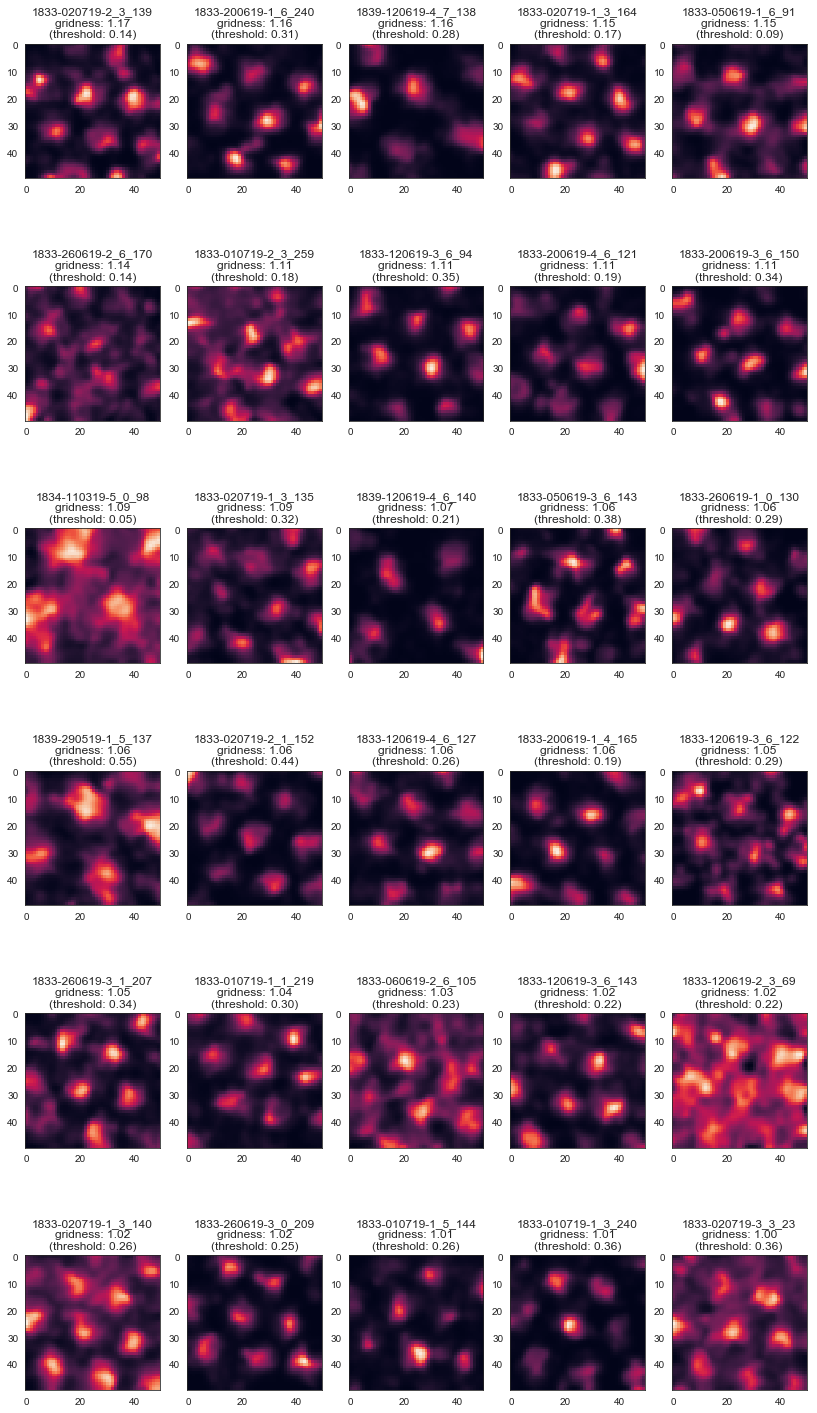

In [67]:
top("gridness")

# Top border score

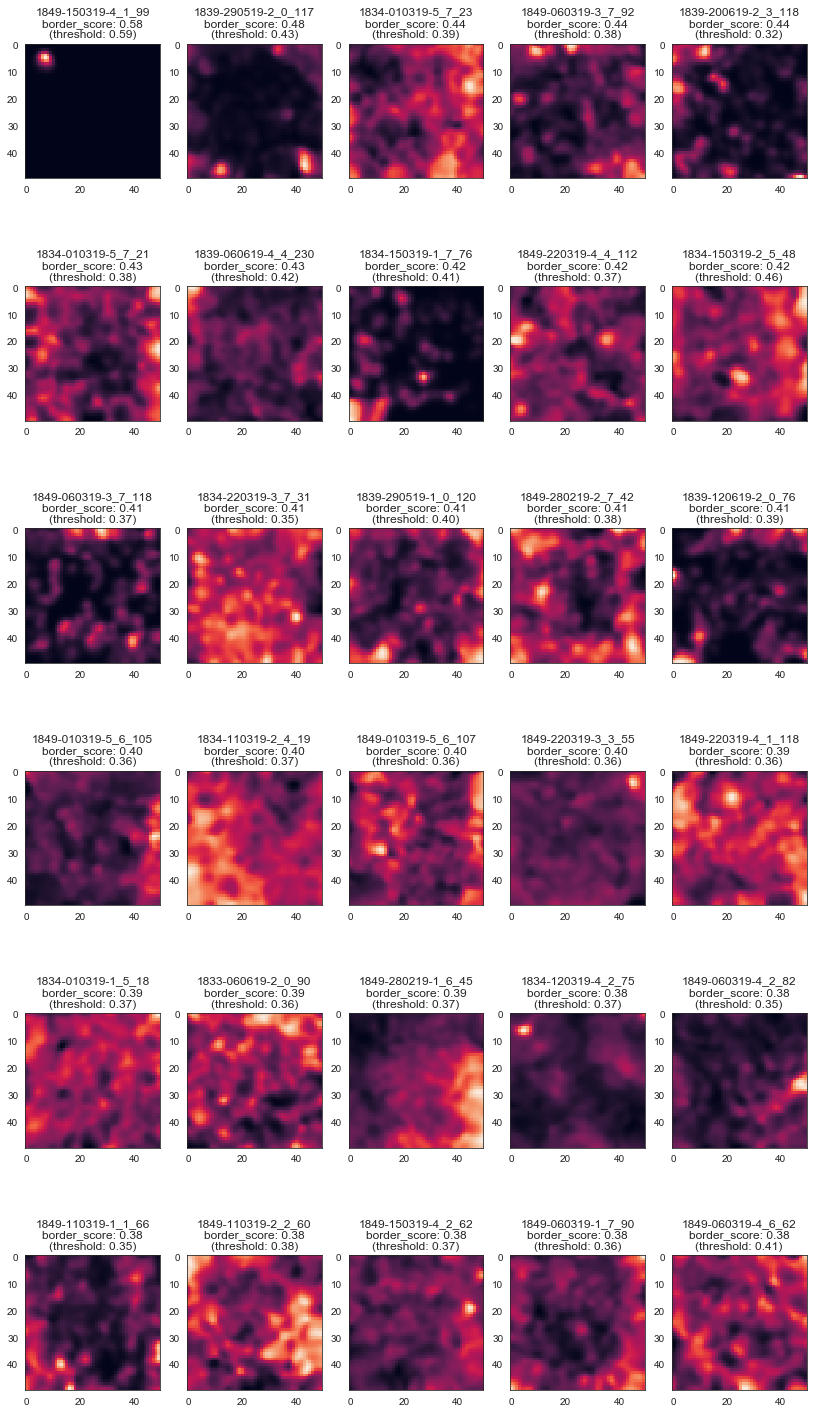

In [68]:
top("border_score")

# Top spatial information

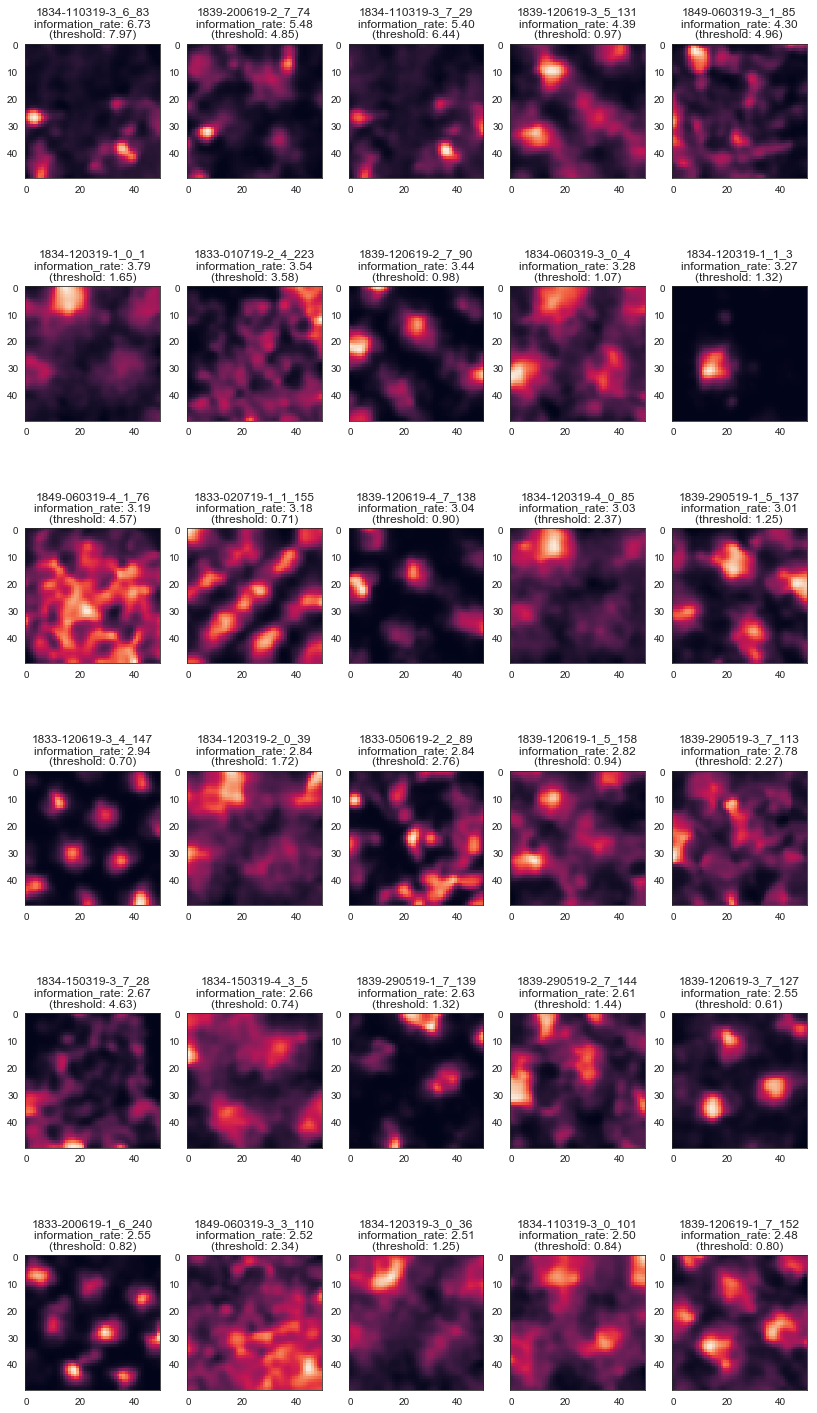

In [69]:
top("information_rate")

# Top head direction

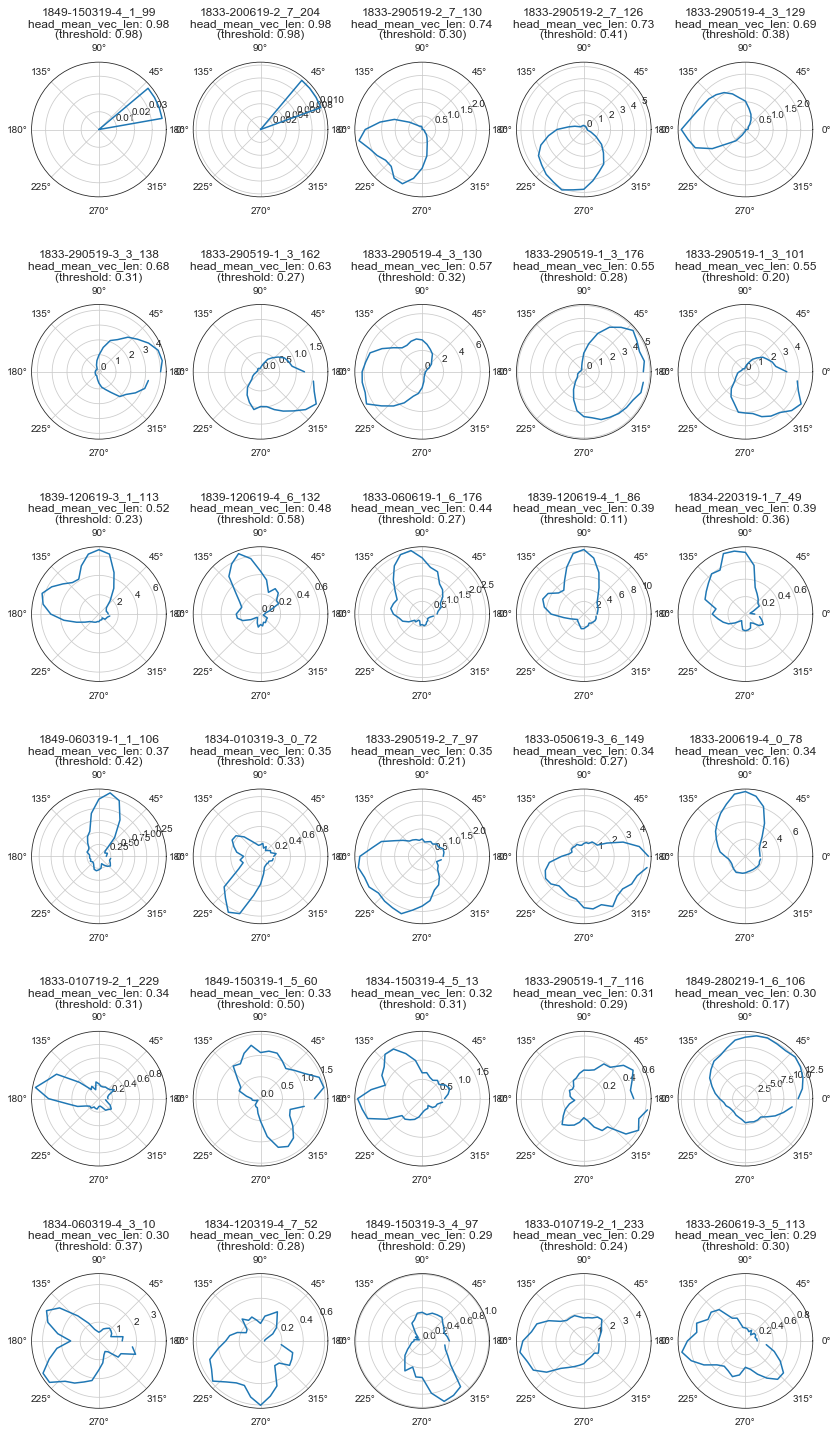

In [70]:
top("head_mean_vec_len")

# Top speed score

/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/elephant/statistics.py:835: UserWarning: Instantaneous firing rate approximation contains negative values, possibly caused due to machine precision errors.
  warnings.warn("Instantaneous firing rate approximation contains "
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


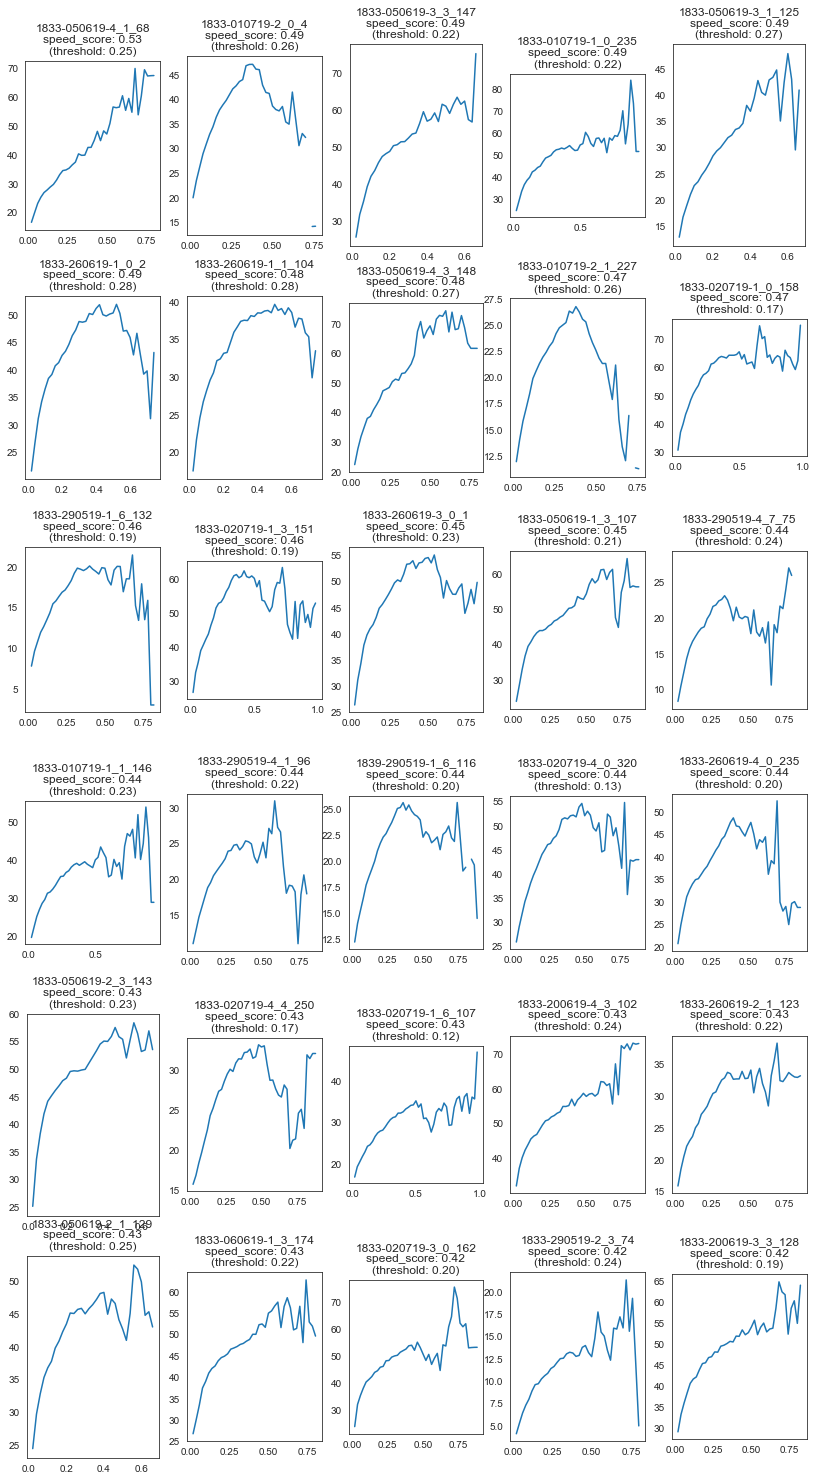

In [71]:
top("speed_score")

# Store results in Expipe action

In [7]:
shuffling_action = project.require_action("shuffling")

In [8]:
shuffling_action.data["shuffling"] = "shuffling.exdir"

In [9]:
copy_tree(output, str(shuffling_action.data_path()))

['/media/storage/expipe/septum-mec/actions/shuffling/data/shuffling.exdir/units/1833-260619-3_6_168/attributes.yaml',
 '/media/storage/expipe/septum-mec/actions/shuffling/data/shuffling.exdir/units/1833-260619-3_6_168/shuffled_rate_map_example/data.npy',
 '/media/storage/expipe/septum-mec/actions/shuffling/data/shuffling.exdir/units/1833-260619-3_6_168/shuffled_rate_map_example/exdir.yaml',
 '/media/storage/expipe/septum-mec/actions/shuffling/data/shuffling.exdir/units/1833-260619-3_6_168/results/quantiles.csv',
 '/media/storage/expipe/septum-mec/actions/shuffling/data/shuffling.exdir/units/1833-260619-3_6_168/results/shuffling_data.csv',
 '/media/storage/expipe/septum-mec/actions/shuffling/data/shuffling.exdir/units/1833-260619-3_6_168/rate_map/data.npy',
 '/media/storage/expipe/septum-mec/actions/shuffling/data/shuffling.exdir/units/1833-260619-3_6_168/rate_map/exdir.yaml',
 '/media/storage/expipe/septum-mec/actions/shuffling/data/shuffling.exdir/units/1833-260619-3_6_168/exdir.yaml'

In [14]:
shuffling_action.modules['parameters'] = {
    'max_speed': max_speed,
    'min_speed': min_speed,
    'position_sampling_rate': position_sampling_rate,
    'position_low_pass_frequency': position_low_pass_frequency,
    'box_size': box_size,
    'bin_size': bin_size,
    'smoothing': smoothing
}

In [11]:
from septum_mec.analysis.registration import store_notebook
store_notebook(
    shuffling_action, "10-shuffling.ipynb")

# delete nonexisting neurons

In [ ]:
# for u in (output / 'shuffling.exdir' / 'units').iterdir():
#     if not u.is_dir():
#         continue
#     action_id, channel_group, unit_name = u.stem.split('_')
#     real_path = pathlib.Path(
#         f'/media/storage/expipe/septum-mec/actions/{action_id}/data/main.exdir/processing/electrophysiology/channel_group_{channel_group}/UnitTimes/{unit_name}'
#     )
#     print(u.stem, real_path.exists())
#     if not real_path.exists():
#         shutil.rmtree(u)